In [2]:
import warnings
warnings.filterwarnings("ignore")
!pip install pycocotools --user

In [29]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
import glob
import matplotlib.pyplot as plt
from keras.models import load_model
import ntpath
from sklearn.metrics import confusion_matrix

In [30]:
IMAGE_SIZE = [224, 224]
train_path = 'PlantVillage\Train'
valid_path = 'PlantVillage\Valid'


In [31]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [32]:
for layer in inception.layers[:249]:
    layer.trainable = False
for layer in inception.layers[249:]:
    layer.trainable = True

In [33]:
folders = glob.glob('PlantVillage\Train\*')
print(len(folders))

15


In [34]:
print("Building model with InceptionV3 with imagenet weights")
model_finetuned = Sequential([
    inception,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(rate=0.2),
    Dense(15, activation='softmax')
])

# tell the model what cost and optimization method to use
model_finetuned.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


model_finetuned.summary()

Building model with InceptionV3 with imagenet weights


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,025,391 (183.20 MB)

 Trainable params: 37,337,487 (142.43 MB)

 Non-trainable params: 10,687,904 (40.77 MB)

In [35]:
model_finetuned.compile(
 loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [37]:
training_set = train_datagen.flow_from_directory('PlantVillage\Train',
                                                 target_size = (224, 224),
                                                 batch_size = 50,
                                                 class_mode = 'categorical')

Found 20638 images belonging to 15 classes.


In [38]:
test_set = test_datagen.flow_from_directory('PlantVillage/Valid/',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1212 images belonging to 15 classes.


In [39]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
history = model_finetuned.fit(
    training_set,
    validation_data=test_set,
    epochs=10,  # Increase epochs if not overfitting
    steps_per_epoch=training_set.samples // training_set.batch_size,
    validation_steps=test_set.samples // test_set.batch_size,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 1476s 4s/step - accuracy: 0.6561 - loss: 2.6546 - val_accuracy: 0.8438 - val_loss: 0.4496 - learning_rate: 0.0010
Epoch 2/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 77s 178ms/step - accuracy: 0.9000 - loss: 0.4838 - val_accuracy: 0.8480 - val_loss: 0.4160 - learning_rate: 0.0010
Epoch 3/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 1450s 4s/step - accuracy: 0.9126 - loss: 0.2596 - val_accuracy: 0.9367 - val_loss: 0.1797 - learning_rate: 0.0010
Epoch 4/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 58s 133ms/step - accuracy: 0.9000 - loss: 0.2642 - val_accuracy: 0.9392 - val_loss: 0.1762 - learning_rate: 0.0010
Epoch 5/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 1440s 3s/step - accuracy: 0.9426 - loss: 0.1749 - val_accuracy: 0.9696 - val_loss: 0.0800 - learning_rate: 0.0010
Epoch 6/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 58s 134ms/step - accuracy: 0.9200 - loss: 0.1776 - val_accuracy: 0.9679 - val_loss: 0.0818 - learning_rate: 0.0010
Epoch 7/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 1587s 4s/step - accuracy: 0.9601 

In [40]:
model_finetuned.save("best_model.keras")  # Saves architecture, weights, and optimizer state


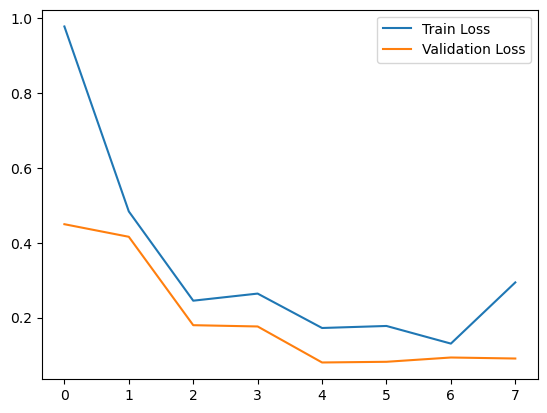

In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [42]:
test_loss, test_acc = model_finetuned.evaluate(test_set)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


38/38 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9652 - loss: 0.0856
Test Accuracy: 0.9695, Test Loss: 0.0803


In [43]:
model_finetuned.save("model.h5")
